## Goal: Build a classification model to predict spend range for tech companies

## Import Libraries and Data

In [105]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [106]:
comp = pd.read_csv("competitive_master.csv")

In [107]:
comp.describe()

,Unnamed: 0,Rank,Revenue_Billion,Financial Year,Employees,Market cap_Billion,Founded,DMA_Code,IsTop31,Total Persons 12+,Month,Spend_K,Year
count,2.159350e+05,215935.000000,215935.000000,215935.000000,215935.000000,212657.000000,215935.000000,215935.000000,215935.000000,2.159350e+05,215935.000000,215935.000000,215935.000000
mean,5.492127e+05,9.805923,114.270432,2017.988617,247026.083641,533.907453,1997.172256,590.466909,0.317308,1.812687e+07,6.893510,44.377307,2018.472230
std,2.986108e+05,12.567042,108.225244,0.106083,290389.640669,415.688519,6.668268,177.225032,0.465430,6.331413e+07,3.438027,708.473195,0.499229
min,0.000000e+00,1.000000,1.050000,2017.000000,1700.000000,0.300000,1981.000000,0.000000,0.000000,8.100000e+03,1.000000,0.000000,2018.000000
25%,3.040425e+05,1.000000,10.500000,2018.000000,20000.000000,100.400000,1994.000000,524.000000,0.000000,8.832000e+05,4.000000,0.000000,2018.000000
50%,5.497940e+05,2.000000,120.800000,2018.000000,103549.000000,791.010000,1998.000000,577.000000,0.000000,1.991600e+06,7.000000,0.000000,2018.000000
75%,8.135210e+05,15.000000,253.900000,2018.000000,647500.000000,972.340000,1999.000000,679.000000,1.000000,4.226900e+06,10.000000,0.300000,2019.000000
max,1.037422e+06,53.000000,253.900000,2018.000000,647500.000000,972.340000,2011.000000,881.000000,1.000000,2.816179e+08,12.000000,91324.500000,2019.000000


In [108]:
comp.columns

Index(['Unnamed: 0', 'INDUSTRY', 'PARENT', 'ADVERTISER', 'BRAND', 'MARKET',
       'MEDIA', 'Company', 'Rank', 'Revenue_Billion', 'Financial Year',
       'Employees', 'Market cap_Billion', 'Founded', 'DMA_Code', 'NIELSEN DMA',
       'Region_Name', 'Division_Name', 'IsTop31', ' Total Persons 12+ ',
       'Month', 'Spend_K', 'Year'],
      dtype='object')

In [109]:
comp=comp.drop('Unnamed: 0', axis=1)

In [110]:
comp=comp.rename(columns={" Total Persons 12+ ":"Audience Population"})

## Data Exploration

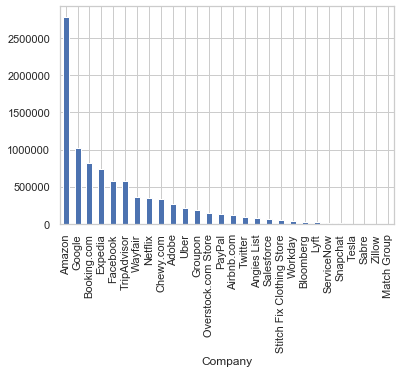

In [111]:
#Competitor's National Advertising Spend Rank

comp[comp['DMA_Code']==0].groupby(['Company'])['Spend_K'].sum().sort_values(ascending=False).plot.bar()


In [112]:
national_spend = comp[(comp['DMA_Code']==0) & (comp['Year']==2018)].groupby(['Company'])['Spend_K'].sum()
avg_revenue = comp[comp['Year']==2018].groupby(['Company'])['Revenue_Billion'].mean()
nat_spend_revenue_ratio = national_spend/avg_revenue/1000000

In [113]:
nat_spend_revenue_ratio.head()

Company
Adobe          0.013870
Airbnb.com     0.020704
Amazon         0.004741
Angies List    0.029709
Bloomberg      0.001041
dtype: float64

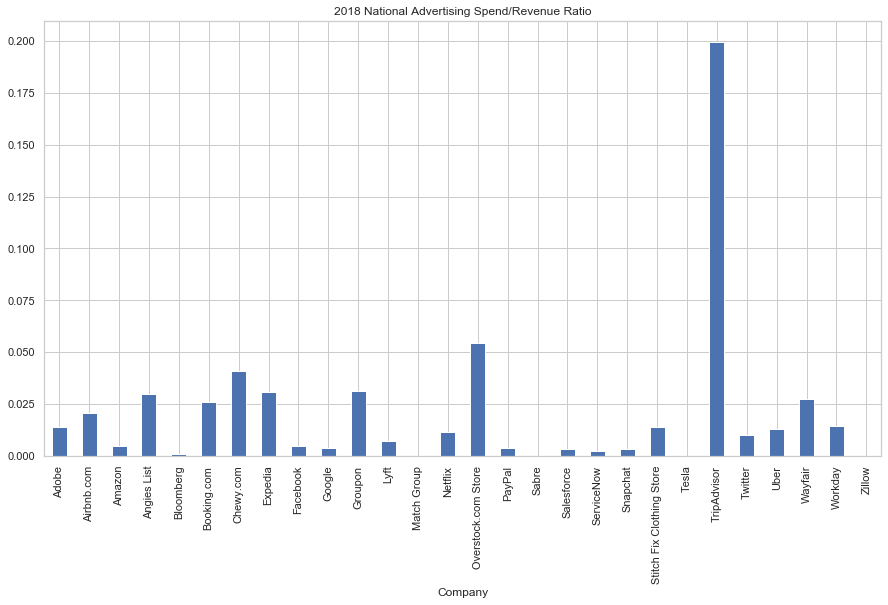

In [114]:
nat_spend_revenue_ratio.plot.bar(figsize=(15,8),title='2018 National Advertising Spend/Revenue Ratio')

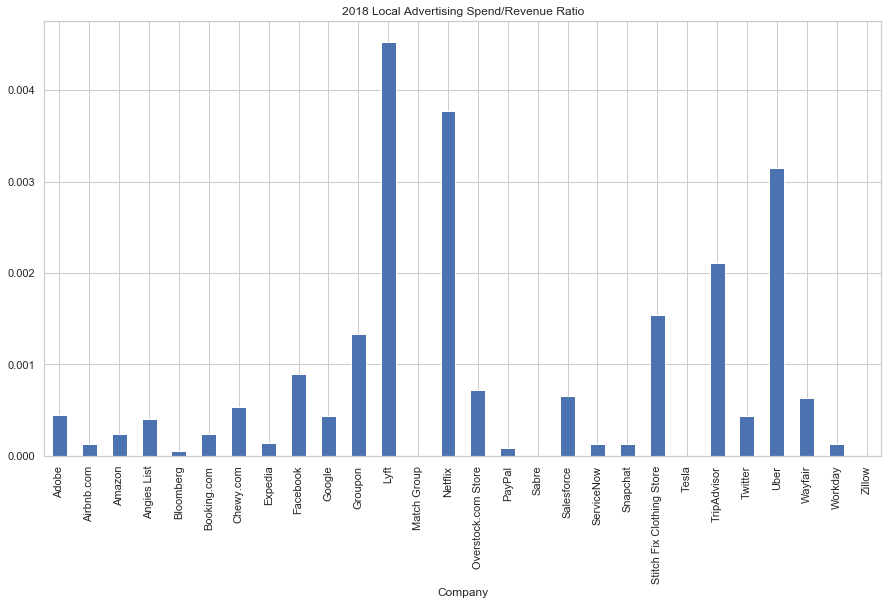

In [115]:
local_spend = comp[(comp['DMA_Code']!=0) & (comp['Year']==2018)].groupby(['Company'])['Spend_K'].sum()
avg_revenue = comp[comp['Year']==2018].groupby(['Company'])['Revenue_Billion'].mean()
local_spend_revenue_ratio = local_spend/avg_revenue/1000000
local_spend_revenue_ratio.plot.bar(figsize=(15,8),title='2018 Local Advertising Spend/Revenue Ratio')

Insight: TripAdvisor spent largest % of their revenue in National advertising, while Lyft, Uber and Netflix spent more in local markets because their marketing efforts are more market-diven

Text(0.5, 1.0, 'Annual Revenue')

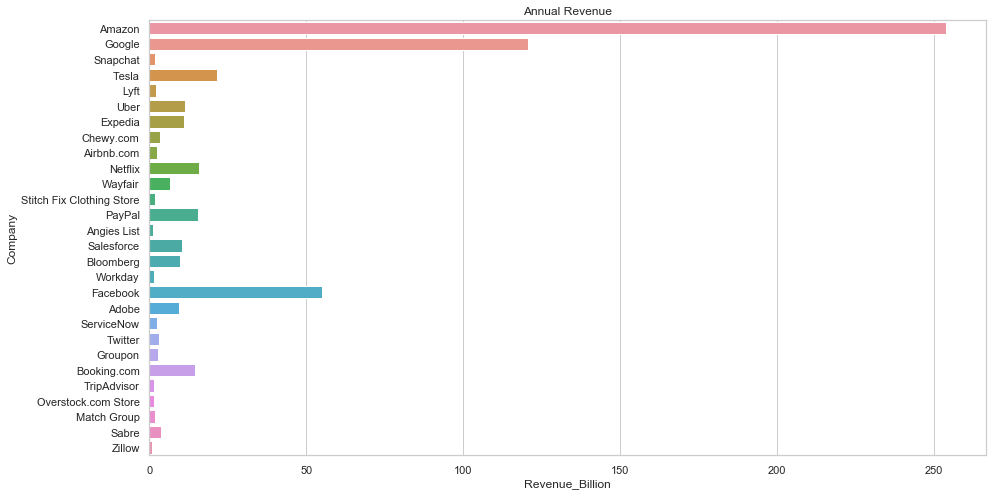

In [116]:
plt.figure(figsize=(15,8))
sns.set(style='whitegrid')
ax = sns.barplot(y='Company', x='Revenue_Billion', data=comp)
plt.title('Annual Revenue')

Add more charts on Media Mix, Market Distribution later


## Data Processing

In [131]:
comp.describe()

,Rank,Revenue_Billion,Financial Year,Employees,Market cap_Billion,Founded,DMA_Code,IsTop31,Audience Population,Month,Spend_K,Year
count,215935.000000,215935.000000,215935.000000,215935.000000,212657.000000,215935.000000,215935.000000,215935.000000,2.159350e+05,215935.000000,215935.000000,215935.000000
mean,9.805923,114.270432,2017.988617,247026.083641,533.907453,1997.172256,590.466909,0.317308,1.812687e+07,6.893510,44.377307,2018.472230
std,12.567042,108.225244,0.106083,290389.640669,415.688519,6.668268,177.225032,0.465430,6.331413e+07,3.438027,708.473195,0.499229
min,1.000000,1.050000,2017.000000,1700.000000,0.300000,1981.000000,0.000000,0.000000,8.100000e+03,1.000000,0.000000,2018.000000
25%,1.000000,10.500000,2018.000000,20000.000000,100.400000,1994.000000,524.000000,0.000000,8.832000e+05,4.000000,0.000000,2018.000000
50%,2.000000,120.800000,2018.000000,103549.000000,791.010000,1998.000000,577.000000,0.000000,1.991600e+06,7.000000,0.000000,2018.000000
75%,15.000000,253.900000,2018.000000,647500.000000,972.340000,1999.000000,679.000000,1.000000,4.226900e+06,10.000000,0.300000,2019.000000
max,53.000000,253.900000,2018.000000,647500.000000,972.340000,2011.000000,881.000000,1.000000,2.816179e+08,12.000000,91324.500000,2019.000000


In [132]:
comp.columns

Index(['INDUSTRY', 'PARENT', 'ADVERTISER', 'BRAND', 'MARKET', 'MEDIA',
       'Company', 'Rank', 'Revenue_Billion', 'Financial Year', 'Employees',
       'Market cap_Billion', 'Founded', 'DMA_Code', 'NIELSEN DMA',
       'Region_Name', 'Division_Name', 'IsTop31', 'Audience Population',
       'Month', 'Spend_K', 'Year'],
      dtype='object')

In [133]:
#Remove Industry, Parent, Advertiser, Brand, Nielsen DMA, Region Name

comp_df = pd.pivot_table(comp, values=['BRAND','Rank','Revenue_Billion','Employees','Market cap_Billion','Founded','IsTop31','Audience Population','Spend_K'],
                        index = ['Company','DMA_Code','MEDIA','Division_Name','Year','Month'],
                        aggfunc={'BRAND':'count', 'Rank':np.mean, 'Revenue_Billion':np.mean, 'Employees':np.mean, 'Market cap_Billion':np.mean, 'Founded':np.mean,'Audience Population': np.mean,'Spend_K':np.sum, 'IsTop31': np.mean })

In [134]:
comp_df = comp_df.reset_index()

There is a huge gap between National Spend and Local Spend. To get more accurate and reasonable mode, we separate National and Local. 

In [135]:
#turn DMA_Code, IsTop31 to Categorical values
comp_df['DMA_Code'] = comp_df['DMA_Code'].astype('category')
comp_df['IsTop31'] = comp_df['IsTop31'].astype('category')

In [136]:
#duplicate Rank as Company ID 
comp_df['Company_ID']=comp_df['Rank'].astype('category')

In [140]:
#Create dummies for MEDIA and Division
media = pd.get_dummies(comp_df['MEDIA'], prefix='Media')
division = pd.get_dummies(comp_df['Division_Name'], prefix='Div')

In [210]:
media

,Media_B-to-B,Media_Cable TV,Media_Hispanic Mags,Media_Hispanic Newsp,Media_Int Display,Media_Int Search,Media_Local Mags,Media_Local Radio,Media_Magazines,Media_Mobile App,...,Media_Natl Spot Radio,Media_Network Radio,Media_Network TV,Media_Newspapers,Media_Online Video,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96033,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96034,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [211]:
division

,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
96031,0,0,0,0,1
96032,0,0,0,0,1
96033,0,0,0,0,1
96034,0,0,0,0,1


In [212]:
comp_df_new = pd.concat([comp_df, media, division],axis=1)

In [263]:
comp_df_new.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
0,Adobe,0,B-to-B,National,2018,1,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
1,Adobe,0,B-to-B,National,2018,4,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
2,Adobe,0,B-to-B,National,2018,8,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
3,Adobe,0,B-to-B,National,2018,9,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
4,Adobe,0,B-to-B,National,2018,10,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0


### National Spend data set

In [254]:
nat_comp_df = comp_df_new[comp_df_new['DMA_Code']==0]
nat_comp_df.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
0,Adobe,0,B-to-B,National,2018,1,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
1,Adobe,0,B-to-B,National,2018,4,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
2,Adobe,0,B-to-B,National,2018,8,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
3,Adobe,0,B-to-B,National,2018,9,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
4,Adobe,0,B-to-B,National,2018,10,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0


In [255]:
nat_comp_df = nat_comp_df.drop(columns=['Company','Div_ALL OTHER','Div_Central','Div_National','Div_Northeast','Div_West','Division_Name','MEDIA','DMA_Code'], axis=1)

#### Create Bins for Spend_K

In [256]:
#Find the Max and Min value by Month
nat_comp_df.describe()

,Year,Month,Audience Population,BRAND,Employees,Founded,Market cap_Billion,Rank,Revenue_Billion,Spend_K,...,Media_Natl Spot Radio,Media_Network Radio,Media_Network TV,Media_Newspapers,Media_Online Video,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication
count,3578.000000,3578.000000,3578.0,3578.000000,3578.000000,3578.000000,3349.000000,3578.000000,3578.000000,3578.000000,...,3578.000000,3578.000000,3578.000000,3578.0,3578.000000,3578.000000,3578.000000,3578.0,3578.000000,3578.000000
mean,2018.502515,6.570430,281617900.0,3.285355,69590.302963,2000.442985,203.038044,21.636389,36.449142,2510.510509,...,0.002795,0.025713,0.077418,0.0,0.124092,0.023197,0.030743,0.0,0.002795,0.025713
std,0.500064,3.444709,0.0,7.310626,175676.818053,7.464891,320.882039,16.221420,71.293360,6593.278018,...,0.052800,0.158299,0.267290,0.0,0.329732,0.150551,0.172646,0.0,0.052800,0.158299
min,2018.000000,1.000000,281617900.0,1.000000,1700.000000,1981.000000,0.300000,1.000000,1.050000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2018.000000,4.000000,281617900.0,1.000000,4500.000000,1996.000000,9.680000,7.000000,2.600000,53.425000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2019.000000,7.000000,281617900.0,1.000000,12000.000000,1999.000000,26.980000,16.000000,9.400000,399.950000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2019.000000,10.000000,281617900.0,2.000000,22900.000000,2005.000000,140.450000,36.000000,15.800000,1799.550000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,2019.000000,12.000000,281617900.0,73.000000,647500.000000,2011.000000,972.340000,53.000000,253.900000,92615.300000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [257]:
nat_comp_df.head()

,Year,Month,Audience Population,BRAND,Employees,Founded,IsTop31,Market cap_Billion,Rank,Revenue_Billion,...,Media_Natl Spot Radio,Media_Network Radio,Media_Network TV,Media_Newspapers,Media_Online Video,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication
0,2018,1,281617900,1,21200,1982,0,131.8,15,9.4,...,0,0,0,0,0,0,0,0,0,0
1,2018,4,281617900,1,21200,1982,0,131.8,15,9.4,...,0,0,0,0,0,0,0,0,0,0
2,2018,8,281617900,1,21200,1982,0,131.8,15,9.4,...,0,0,0,0,0,0,0,0,0,0
3,2018,9,281617900,1,21200,1982,0,131.8,15,9.4,...,0,0,0,0,0,0,0,0,0,0
4,2018,10,281617900,1,21200,1982,0,131.8,15,9.4,...,0,0,0,0,0,0,0,0,0,0


In [258]:
#Use Amazon and Zillow as Upper and Lower Bound
nat_comp_df.Company_ID.unique()

[15, 39, 1, 50, 14, ..., 32, 16, 18, 41, 52]
Length: 28
Categories (28, int64): [15, 39, 1, 50, ..., 16, 18, 41, 52]

In [264]:
nat_comp_df[nat_comp_df['Company_ID']==1].describe()

,Year,Month,Audience Population,BRAND,Employees,Founded,Market cap_Billion,Rank,Revenue_Billion,Spend_K,...,Media_Natl Spot Radio,Media_Network Radio,Media_Network TV,Media_Newspapers,Media_Online Video,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication
count,298.000000,298.000000,298.0,298.000000,298.0,298.0,2.980000e+02,298.0,2.980000e+02,298.000000,...,298.000000,298.000000,298.000000,298.0,298.000000,298.000000,298.000000,298.0,298.000000,298.000000
mean,2018.510067,6.708054,281617900.0,13.244966,647500.0,1994.0,9.723400e+02,1.0,2.539000e+02,9353.909396,...,0.026846,0.080537,0.080537,0.0,0.080537,0.050336,0.046980,0.0,0.013423,0.067114
std,0.500740,3.470705,0.0,19.191321,0.0,0.0,5.648246e-13,0.0,1.846730e-13,14731.494141,...,0.161904,0.272580,0.272580,0.0,0.272580,0.219004,0.211952,0.0,0.115270,0.250640
min,2018.000000,1.000000,281617900.0,1.000000,647500.0,1994.0,9.723400e+02,1.0,2.539000e+02,0.200000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2018.000000,4.000000,281617900.0,2.000000,647500.0,1994.0,9.723400e+02,1.0,2.539000e+02,369.725000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2019.000000,7.000000,281617900.0,4.000000,647500.0,1994.0,9.723400e+02,1.0,2.539000e+02,2345.050000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2019.000000,10.000000,281617900.0,13.750000,647500.0,1994.0,9.723400e+02,1.0,2.539000e+02,11510.775000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,2019.000000,12.000000,281617900.0,73.000000,647500.0,1994.0,9.723400e+02,1.0,2.539000e+02,92615.300000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [265]:
nat_comp_df.Spend_K.quantile(list(np.linspace(0,1,20)))

0.000000        0.000000
0.052632        1.300000
0.105263        7.000000
0.157895       16.557895
0.210526       34.005263
0.263158       60.200000
0.315789       98.094737
0.368421      153.910526
0.421053      225.210526
0.473684      340.436842
0.526316      459.331579
0.578947      638.326316
0.631579      894.842105
0.684211     1250.868421
0.736842     1683.552632
0.789474     2324.131579
0.842105     3417.510526
0.894737     5731.210526
0.947368    10657.600000
1.000000    92615.300000
Name: Spend_K, dtype: float64

In [266]:
#75% values are between 0 to 12000
BINS = [0,5,10,20,50,80,100,150,200,300,500,800,1000,1500,2000,2500,3000,4000,5000,8000,10000,15000,20000,100000]

In [268]:
nat_comp_df['Spend_Bins'] = pd.cut(x=nat_comp_df.Spend_K, bins=BINS, labels=False)

In [269]:
nat_comp_df['Spend_Bins']

0         9.0
1         1.0
2         8.0
3         9.0
4        10.0
         ... 
95727     0.0
95728     0.0
95729     0.0
95730     0.0
95731     3.0
Name: Spend_Bins, Length: 3578, dtype: float64

In [270]:
nat_comp_df = nat_comp_df.drop('Spend_K', axis=1)

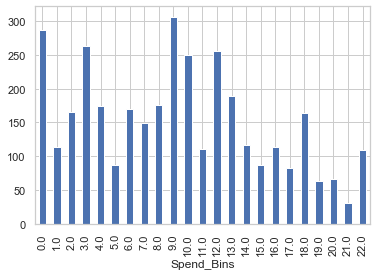

In [271]:
nat_comp_df.groupby('Spend_Bins')['BRAND'].count().plot.bar()

In [272]:
#Remove all NAs
nat_comp_df = nat_comp_df.dropna(how='any')

## Training, testing and cross-validation

In [273]:
#Split the data into training and test sets
y = nat_comp_df['Spend_Bins']
X = nat_comp_df.drop('Spend_Bins', axis=1)

In [274]:
y

0         9.0
1         1.0
2         8.0
3         9.0
4        10.0
         ... 
95727     0.0
95728     0.0
95729     0.0
95730     0.0
95731     3.0
Name: Spend_Bins, Length: 3306, dtype: float64

### Standaridize the data set

In [275]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
scaled_features = pd.DataFrame(scaled, columns=X.columns)

In [276]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.25, random_state=4)

## Build the Base Model

In [277]:
#Instantiate and fit a RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 20, max_depth=10)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [278]:
forest.score(X_train, y_train)

0.6805163372327552

In [279]:
forest.score(X_test, y_test)

0.282950423216445

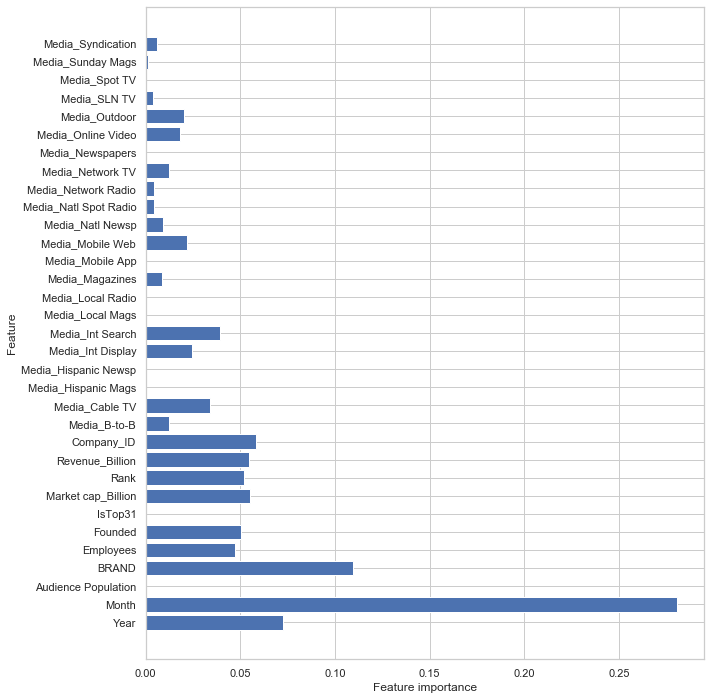

In [283]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


plot_feature_importances(forest)

### Local Spend data set

In [153]:
a = comp_df_new[comp_df_new['DMA_Code']!=0].groupby('Year')

In [98]:
local_comp_df = comp_df_new[comp_df_new['DMA_Code']!=0]

In [101]:
comp_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288108 entries, 0 to 96035
Data columns (total 43 columns):
Company                  96036 non-null object
DMA_Code                 96036 non-null object
MEDIA                    96036 non-null object
Division_Name            96036 non-null object
Year                     96036 non-null float64
Month                    96036 non-null float64
Audience Population      96036 non-null float64
BRAND                    96036 non-null float64
Employees                96036 non-null float64
Founded                  96036 non-null float64
IsTop31                  96036 non-null object
Market cap_Billion       93351 non-null float64
Rank                     96036 non-null float64
Revenue_Billion          96036 non-null float64
Spend_K                  96036 non-null float64
Company_ID               96036 non-null object
Media_B-to-B             96036 non-null float64
Media_Cable TV           96036 non-null float64
Media_Hispanic Mags      96036 n

In [ ]:
comp_df_new = comp_df_new.drop(columns=[''])